# Demo of matching using steerers
Before running this notebook, install the `rotation_steerers` package as described in `README.md`.

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import torch
    import numpy as np
    from PIL import Image
    import cv2
    import matplotlib.pyplot as plt

In [2]:
# Helper function for drawing matches
def draw_img_match(img1, img2, mkpts1, mkpts2, reverse_pair=True):
    if isinstance(img1, torch.Tensor):
        img1 = im_tensor_to_np(img1)
    if isinstance(img2, torch.Tensor):
        img2 = im_tensor_to_np(img2)
    if isinstance(mkpts1, torch.Tensor):
        mkpts1 = mkpts1.detach().cpu().numpy()
    if isinstance(mkpts2, torch.Tensor):
        mkpts2 = mkpts2.detach().cpu().numpy()
    
    if isinstance(img1, np.ndarray):
        img1 = np.uint8(255 * img1)
    else:
        img1 = cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB)
    if isinstance(img2, np.ndarray):
        img2 = np.uint8(255 * img2)
    else:
        img2 = cv2.cvtColor(cv2.imread(img2), cv2.COLOR_BGR2RGB)
    
    if reverse_pair:
        img1, img2, = img2, img1
        mkpts1, mkpts2 = mkpts2, mkpts1
    
    img = cv2.drawMatches(
        img1=img1,
        keypoints1=[cv2.KeyPoint(x=x, y=y, size=2) for x, y in mkpts1],
        img2=img2,
        keypoints2=[cv2.KeyPoint(x=x, y=y, size=2) for x, y in mkpts2],
        matches1to2=[cv2.DMatch(_trainIdx=i, _queryIdx=i, _distance=-1.) for i in range(len(mkpts1))],
        matchesThickness=2,
        outImg=None,
    ) 
    plt.imshow(img)
        
def im_tensor_to_np(x):
    return x[0].permute(1, 2, 0).detach().cpu().numpy()

## Matching using ordinary DeDoDe
We begin by demonstrating matches obtained by the original DeDoDe-B descriptor on rotated images.
For more difficult matching change `im = "example_images/im_A.jpg"` to `im = "example_images/im_B.jpg"` below. 

In [3]:
im = "example_images/im_A.jpg"
im_rot = "example_images/im_A_rot.jpg"

In [4]:
im_pil = Image.open(im)
w, h = im_pil.size
im_rot_pil = Image.open(im_rot)
w_rot, h_rot = im_rot_pil.size

In [5]:
from DeDoDe import dedode_detector_L, dedode_descriptor_B
from rotation_steerers.matchers.dual_softmax_matcher import DualSoftMaxMatcher

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    detector = dedode_detector_L(weights = torch.load("model_weights/dedode_detector_L.pth"))
    descriptor = dedode_descriptor_B(weights = torch.load("model_weights/dedode_descriptor_B.pth"))
    matcher = DualSoftMaxMatcher()

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    detections = detector.detect_from_path(im, num_keypoints = 5_000)
    keypoints, P = detections["keypoints"], detections["confidence"]
    
    detections_rot = detector.detect_from_path(im_rot, num_keypoints = 5_000)
    keypoints_rot, P_rot = detections_rot["keypoints"], detections_rot["confidence"]

In [8]:
descriptions = descriptor.describe_keypoints_from_path(im, keypoints)["descriptions"]
descriptions_rot = descriptor.describe_keypoints_from_path(im_rot, keypoints_rot)["descriptions"]

In [9]:
matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

666


We plot only 100 matches for ease of viewing. DeDoDe-matches are quite poor for rotated images.

(-0.5, 3199.5, 1184.5, -0.5)

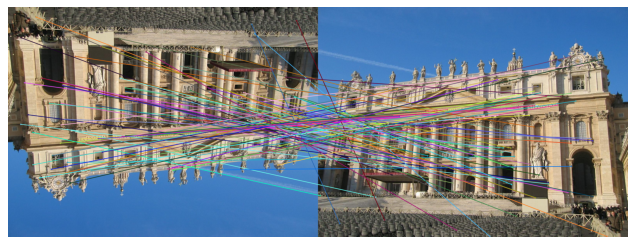

In [10]:
plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

## Matching in Setting A
For the given DeDoDe descriptor, we have optimized a steerer. We now demonstrate the improved matches this gives.

In [11]:
from rotation_steerers.matchers.max_matches import MaxMatchesMatcher, SubsetMatcher
from rotation_steerers.steerers import DiscreteSteerer
steerer_generator = torch.load("model_weights/B_C4_steerer_setting_A.pth")
steerer = DiscreteSteerer(steerer_generator)
matcher = MaxMatchesMatcher(steerer=steerer, steerer_order=4)

3337


(-0.5, 3199.5, 1184.5, -0.5)

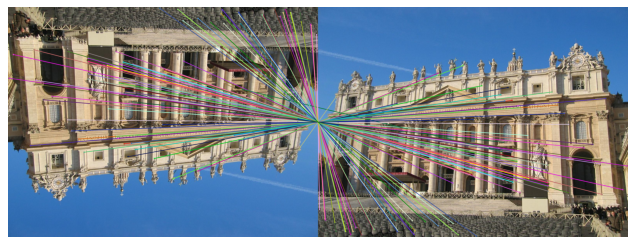

In [12]:
matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

## Matching in Setting C
We fix the steerer to be a permutation matrix (see the *Perm* model in the paper) and optimize a descriptor for it. This gives even better matches.

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    descriptor = dedode_descriptor_B(weights = torch.load("model_weights/B_C4_Perm_descriptor_setting_C.pth"))
steerer.generator = torch.load("model_weights/B_C4_Perm_steerer_setting_C.pth")
matcher = MaxMatchesMatcher(steerer=steerer, steerer_order=4)

3440


(-0.5, 3199.5, 1184.5, -0.5)

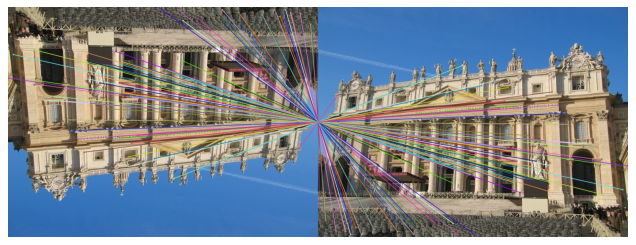

In [14]:
descriptions = descriptor.describe_keypoints_from_path(im, keypoints)["descriptions"]
descriptions_rot = descriptor.describe_keypoints_from_path(im_rot, keypoints_rot)["descriptions"]

matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

### Further matching techniques
We also demonstrate the *Max similarity* and *Subset* matching strategies described in the paper.

3421


(-0.5, 3199.5, 1184.5, -0.5)

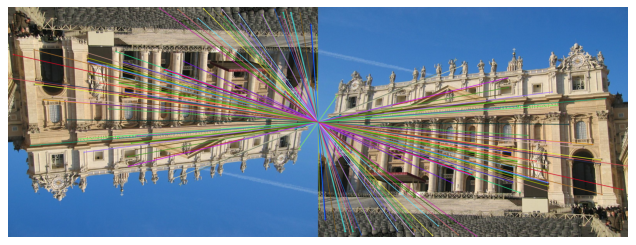

In [15]:
from rotation_steerers.matchers.max_similarity import MaxSimilarityMatcher

matcher = MaxSimilarityMatcher(steerer=steerer, steerer_order=4)

matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

3440


(-0.5, 3199.5, 1184.5, -0.5)

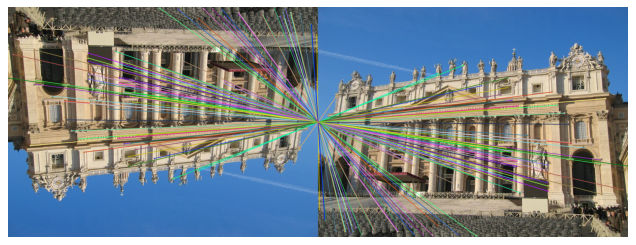

In [16]:
matcher = SubsetMatcher(steerer=steerer, steerer_order=4)

matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

## SO(2) steerer in setting B
Finally, we demonstrate an $\mathrm{SO}(2)$-steerer. This one is the *Spread* model described in the paper. We discretize the steerer to a $C_8$-steerer by using the matrix exponential below. This steerer was trained in setting B, i.e. the steerer and descriptor were trained jointly.

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    descriptor = dedode_descriptor_B(weights = torch.load("model_weights/B_SO2_Spread_descriptor_setting_B.pth"))
steerer.generator = torch.matrix_exp(0.25 * np.pi * torch.load("model_weights/B_SO2_Spread_steerer_setting_B.pth"))
matcher = MaxSimilarityMatcher(steerer=steerer, steerer_order=8)

3398


(-0.5, 3199.5, 1184.5, -0.5)

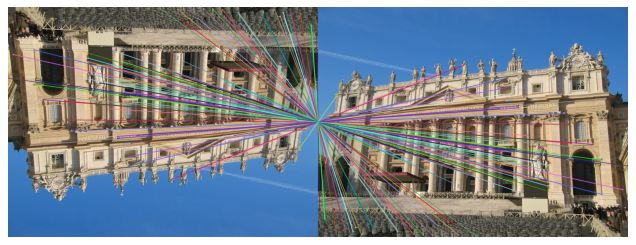

In [18]:
descriptions = descriptor.describe_keypoints_from_path(im, keypoints)["descriptions"]
descriptions_rot = descriptor.describe_keypoints_from_path(im_rot, keypoints_rot)["descriptions"]

matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

If we want to use arbitrary angles, we can use a `ContinuousSteerer` and (for instance) a `ContinuousMaxMatchesMatcher`. This has a slight computational overhead as we run `torch.matrix_exp` in each call of the steerer.

2484


(-0.5, 3199.5, 1184.5, -0.5)

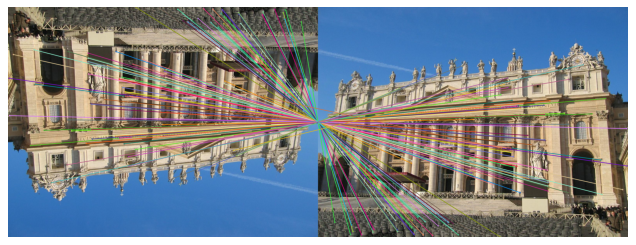

In [19]:
from rotation_steerers.steerers import ContinuousSteerer
from rotation_steerers.matchers.max_similarity import ContinuousMaxSimilarityMatcher
from rotation_steerers.matchers.max_matches import ContinuousMaxMatchesMatcher, ContinuousSubsetMatcher
continuous_steerer = ContinuousSteerer(generator=torch.load("model_weights/B_SO2_Spread_steerer_setting_B.pth"))
matcher = ContinuousMaxMatchesMatcher(angles=[0.1, 1.9, 3.8], steerer=continuous_steerer)  # angles in radians (correct is 3.14)

descriptions = descriptor.describe_keypoints_from_path(im, keypoints)["descriptions"]
descriptions_rot = descriptor.describe_keypoints_from_path(im_rot, keypoints_rot)["descriptions"]

matches, matches_rot, batch_ids = matcher.match(
    keypoints, descriptions,
    keypoints_rot, descriptions_rot,
    P_A = P, P_B = P_rot,
    normalize = True, inv_temp=20, threshold = 0.01
)

matches, matches_rot = matcher.to_pixel_coords(
    matches, 
    matches_rot, 
    h, 
    w, 
    h_rot, 
    w_rot,
)

print(len(matches))

plt.figure(figsize=(10,5), dpi=80)
draw_img_match(im, im_rot, matches[:100], matches_rot[:100])
plt.axis('off')

## Plotting the steerer
It is also interesting to plot the steerer itself. Below we plot $\rho(\mathbf{g})^k$ for a $C_4$ steerer optimized for the original DeDoDe-descriptor. We see that it looks like random noise up until $\rho(\mathbf{g})^4$ at which point we get a matrix approximately proportional to the identity matrix showing that $\rho$ is a representation of $C_4$ i.e. a valid steerer.

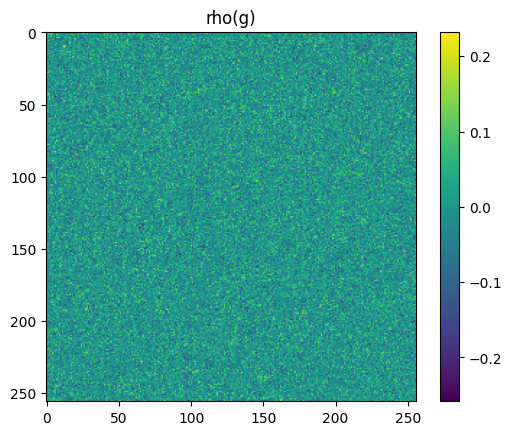

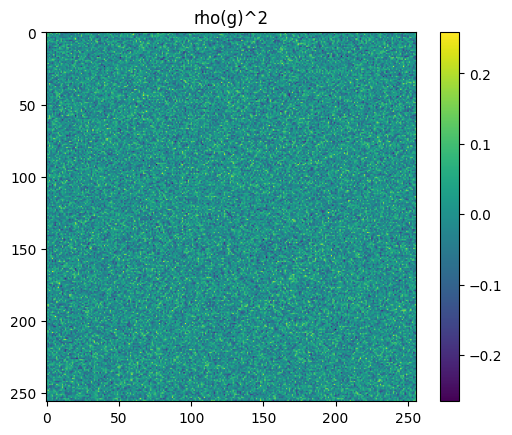

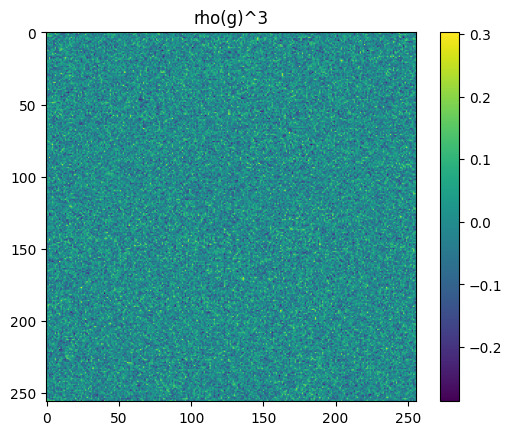

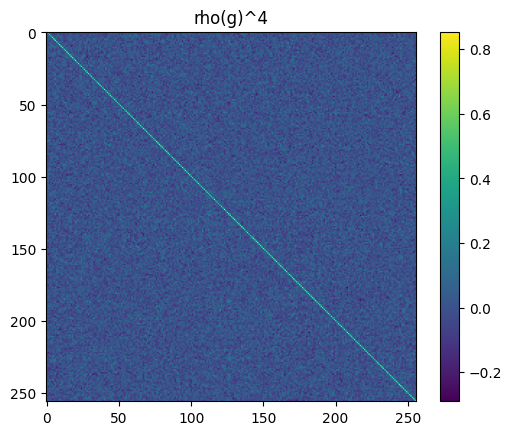

In [20]:
rho_g = torch.load("model_weights/B_C4_steerer_setting_A.pth").cpu().numpy()
plt.imshow(rho_g)
plt.title("rho(g)")
plt.colorbar()
plt.show()

plt.imshow(rho_g @ rho_g)
plt.title("rho(g)^2")
plt.colorbar()
plt.show()

plt.imshow(rho_g @ rho_g @ rho_g)
plt.title("rho(g)^3")
plt.colorbar()
plt.show()

plt.imshow(rho_g @ rho_g @ rho_g @ rho_g)
plt.title("rho(g)^4")
plt.colorbar()
plt.show()

Finally, we plot the Lie-algebra generator $\mathrm{d}\varsigma$ and $\mathrm{expm}(2\pi\mathrm{d}\varsigma)$. As seen in the eigenvalue plots, the higher frequencys are not well used here but for the lower frequencies we get a nice diagonal structure of $\mathrm{expm}(2\pi\mathrm{d}\varsigma)$.

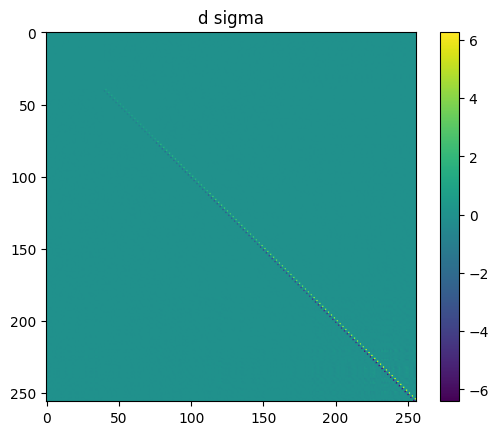

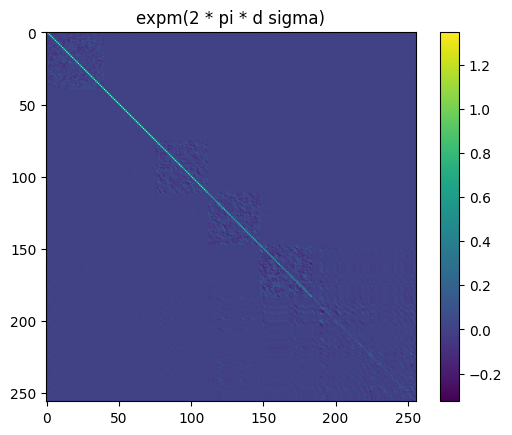

In [21]:
d_sigma = torch.load("model_weights/B_SO2_Spread_steerer_setting_B.pth").cpu()
plt.imshow(d_sigma)
plt.title("d sigma")
plt.colorbar()
plt.show()

plt.imshow(torch.matrix_exp(2*np.pi*d_sigma))
plt.title("expm(2 * pi * d sigma)")
plt.colorbar()
plt.show()